## Семинар 3 "Определение ключевых точек лица"

Радионов Максим Анатольевич

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  21 октября 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
from torch import nn                                                            
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter, ReLU
from torch.autograd import Variable
# Ignore warnings
import warnings


# try:
#     from tensorboardX import SummaryWriter
# except ImportError:
#     raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -r /content/dataset

rm: cannot remove '/content/dataset': No such file or directory


In [4]:
%%time
%cp '/content/drive/My Drive/colab_data/neural/dataset.zip' '/content/'
%cd '/content/'
!unzip dataset.zip
%ls

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: dataset/train/3255.jpeg  
 extracting: dataset/train/216.jpeg  
 extracting: dataset/train/3619.jpeg  
 extracting: dataset/train/3227.jpeg  
 extracting: dataset/train/3520.jpeg  
 extracting: dataset/train/1492.jpeg  
 extracting: dataset/train/3937.jpeg  
 extracting: dataset/train/2885.jpeg  
 extracting: dataset/train/2704.jpeg  
 extracting: dataset/train/4373.jpeg  
 extracting: dataset/train/379.jpeg  
 extracting: dataset/train/6275.jpeg  
 extracting: dataset/train/1046.jpeg  
 extracting: dataset/train/6492.jpeg  
 extracting: dataset/train/6725.jpeg  
 extracting: dataset/train/6919.jpeg  
 extracting: dataset/train/4341.jpeg  
 extracting: dataset/train/168.jpeg  
 extracting: dataset/train/1650.jpeg  
 extracting: dataset/train/5572.jpeg  
 extracting: dataset/train/2624.jpeg  
 extracting: dataset/train/4136.jpeg  
 extracting: dataset/train/1421.jpeg  
 extracting: dataset/train/1655.jpeg  

In [5]:
ls

dataset/  dataset.zip  drive/  sample_data/


In [6]:
# %load train_utils.py                                                          
import numpy as np                                                              
#from sklearn.datasets import fetch_mldata                                      
from sklearn.model_selection import train_test_split                            
import matplotlib.pyplot as plt                                                 
import torch                                                                    
from torch import nn                                                            
from torch.utils.data import DataLoader                                         
from torchvision.datasets import MNIST                                          
from torchvision import transforms                                              
import sys                                                                      
from IPython.display import clear_output                                        


In [7]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample


In [8]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        image = np.array([image])
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)
        

In [9]:
trans = transforms.Compose([ToTensor()])

train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())


In [10]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4
    )
    test_loader = DataLoader(
        test_dataset, batch_size=len(test_dataset),shuffle=False)

    return train_loader, test_loader


In [11]:
def _epoch(network, loss, loader,                                               
           backward=True,                                                       
           optimizer=None,                                                      
           device='cpu',                                                        
           ravel_init=False):                                                   
    losses = []                                                                 
    for X, y in loader:                                                         
        X = X.to(device)                                                        
        y = y.to(device)                                                        
        if ravel_init:                                                          
            X = X.view(X.size(0), -1)                                           
        network.zero_grad()                                                     
        prediction = network(X)                                                 
        loss_batch = loss(prediction, y.view(y.size(0), 68*2))                                       
        losses.append(loss_batch.cpu().item())                                  
        if backward:                                                            
            loss_batch.backward()                                               
            optimizer.step()                                                    
        #prediction = prediction.max(1)[1]                                       
    return losses


def train(network, train_loader, test_loader,                                   
          epochs, learning_rate, loss=nn.MSELoss(), ravel_init=False,           
          device='cpu', tolerate_keyboard_interrupt=True, drop_epoch=0, adaptive_lr=False):                      
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)        
    train_loss_epochs = []                                                      
    test_loss_epochs = []                                                       
    network = network.to(device)                                                
    try:                                                                        
        for epoch in range(epochs):                                             
            network.train()                                                     
            if adaptive_lr:
              if((1+epoch)%6 == 0):
                learning_rate = learning_rate/1.5
                for param_group in optimizer.param_groups:
                  param_group['lr'] = learning_rate
                print('change lr ', learning_rate)
            losses = _epoch(network,                                
                                        loss,                                   
                                        train_loader,                           
                                        True,                                   
                                        optimizer,                              
                                        device,                                 
                                        ravel_init)                             

            if epoch >= drop_epoch: 
              train_loss_epochs.append(np.mean(losses))                           
            network.eval()                                                      
            losses= _epoch(network,                                
                                        loss,                                   
                                        test_loader,                            
                                        False,                                  
                                        optimizer,                              
                                        device,                                 
                                        ravel_init)                             
            clear_output(True)                                                  
            if epoch >= drop_epoch: 
              test_loss_epochs.append(np.mean(losses))                            
              print('Epoch {0} lr {1:.4f}... (Train/Test) Loss: {2:.3f}/{3:.3f}\t'.format(
                          epoch, learning_rate, train_loss_epochs[-1], test_loss_epochs[-1]))   
              plt.figure(figsize=(20, 10))                                         
              plt.subplot(1, 1, 1)                                                
              plt.plot(train_loss_epochs, label='Train')                          
              plt.plot(test_loss_epochs, label='Test')                            
              plt.xlabel('Epochs', fontsize=16)             
              plt.ylabel('Loss', fontsize=16)                                     
              plt.legend(loc=0, fontsize=16)                                      
              plt.grid()                                                          
              plt.show()                                                          
    except KeyboardInterrupt:                                                   
        if tolerate_keyboard_interrupt:                                         
            pass                                                                
        else:                                                                   
            raise KeyboardInterrupt                                             
    return train_loss_epochs, test_loss_epochs

In [31]:
class Net(Module):
    def __init__(self, activation=ReLU(), latent_size=200):
        super().__init__()
        drop_level = 0.05
        self.conv_layers = nn.Sequential(
                                         nn.Conv2d(1, 16, 3, padding=1),  
                                         nn.BatchNorm2d(16),                   
                                         nn.ReLU(),
                                         #nn.Dropout(p=drop_level),
                                         nn.MaxPool2d(2),
                                         
                                         nn.Conv2d(16,32, 3, padding=1), 
                                         nn.BatchNorm2d(32),                   
                                         nn.ReLU(),
                                         #nn.Dropout(p=drop_level),
                                         nn.MaxPool2d(2),

                                         nn.Conv2d(32, 64, 3, padding=1), 
                                         nn.BatchNorm2d(64),                   
                                         nn.ReLU(),
                                         #nn.Dropout(p=drop_level),
                                         nn.MaxPool2d(3),

                                        #  nn.Conv2d(32, 64, 3, padding=1), 
                                        #  nn.BatchNorm2d(64),                   
                                        #  nn.ReLU(),
                                        #  #nn.Dropout(p=drop_level),
                                        #  nn.MaxPool2d(2),
                                        )
                                                 
        
        self.linear_layers = nn.Sequential(
                                           nn.Linear(4096, 68*2*2), 
                                           nn.BatchNorm1d(68*2*2),
                                           nn.ReLU(),
                                           nn.Dropout(p=drop_level),

                                           nn.Linear(68*2*2,68*2),
                                           )
        
        torch.nn.init.xavier_normal_(self.conv_layers[0].weight)
        torch.nn.init.xavier_normal_(self.conv_layers[4].weight)
        torch.nn.init.xavier_normal_(self.conv_layers[8].weight)
        torch.nn.init.xavier_normal_(self.linear_layers[0].weight)
        torch.nn.init.xavier_normal_(self.linear_layers[4].weight)

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear_layers(x) 
        return x

In [32]:
train_dataloader, test_dataloader = get_data_loaders(train_batch_size=64)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
network = Net()

Тут был еще один вызов train на 80 эпох

Epoch 63 lr 0.0009... (Train/Test) Loss: 2.178/3.548	


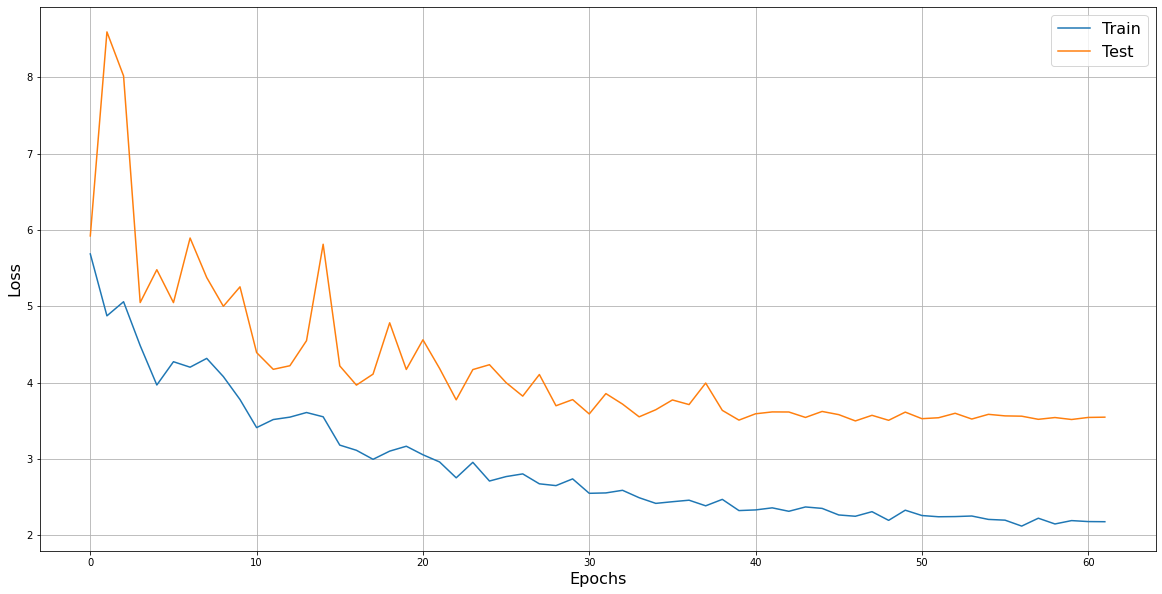

CPU times: user 2min 51s, sys: 25.7 s, total: 3min 17s
Wall time: 7min 8s


In [34]:
%%time
_,_ = train(network,train_dataloader,test_dataloader,80, 0.05, loss=nn.MSELoss(), ravel_init=False,device=device, drop_epoch=2, adaptive_lr=True)


Epoch 49 lr 0.0020... (Train/Test) Loss: 1.983/3.433	


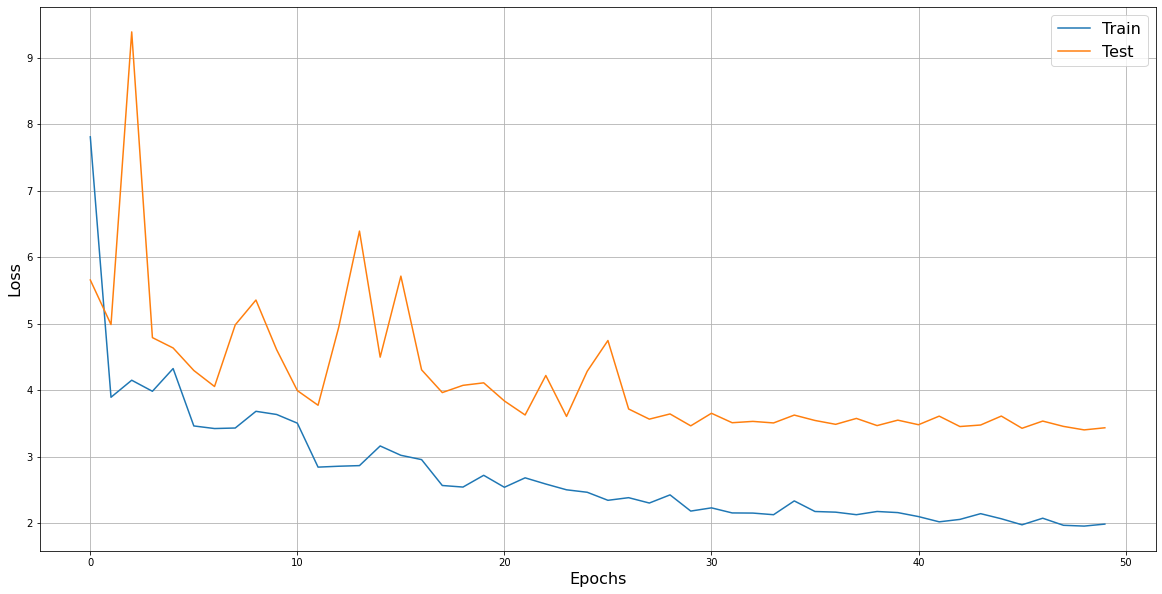

CPU times: user 2min 17s, sys: 20.3 s, total: 2min 37s
Wall time: 5min 41s


In [36]:
%%time
_,_ = train(network,train_dataloader,test_dataloader,50, 0.05, loss=nn.MSELoss(), ravel_init=False,device=device, drop_epoch=0, adaptive_lr=True)


В итоге примерный лос на тесте - 3.43. Использовал свертки, пулинг, дропаут, батч нормализацию, адаптивный лернинг рейт. Заметил такую особенность, если обучать сеть как бы в два этапа. То есть если обучить сеть до насыщения, а потом заново вызвать train ( то есть пересоздать оптимайзер) то лос сначала увеличивается, а потом становится ниже чем после первого этапа. Сама сеть не пересоздается. Не знаю с чем связан такой эффект